# BLG202E - Numerical Methods in Comp. Eng. (21332)

## Project No 4: Item-based Filtering Enhanced by SVD

### Name-Surname: Serdar Biçici

### Student Number: 150210331




In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cupy as cp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data_file = "/content/drive/MyDrive/GDB - foto/sample.json"

## Example Json Item

In [ ]:
#{'review_id': 'rw1133942',
#'reviewer': 'OriginalMovieBuff21',
#'movie': 'Kill Bill: Vol. 2 (2004)',
#'rating': '8',
#'review_summary': 'Good follow up that answers all the questions',
#'review_date': '24 July 2005',
#'spoiler_tag': 0,
#'review_detail': "After seeing Tarantino's Kill Bill Vol: 1, I got to watch Vol. 2 the next day after seeing it. I liked the first one but didn't really know everything that was going on, but just knowing that she set off the kill 5 individuals who left her dead at her wedding. So I saw Kill Bill: Vol 2 and liked it highly. The movie answered all of my questions to the previous one and had much of a better story and was not unrealistic that much. We finally get to see Bill, who is played by David Carradine who had a really good role in the movie. There is a great conclusion to the movie and had a very good story, along with likable characters, my favorite being Budd. Overall, good movie that answers tons of questions. I recommend Kill Bill Vol. 2.Hedeen's Outlook: 8/10 *** B",
#'helpful': ['0', '1']}

## Data Reading and Saving

In [9]:
movies = set()
reviewers = dict()

In [10]:
def read_json(filename):
    """
    Reads json file, adds movie to a set and reviewer to dict for later data preproccessing

    args:
        filename<str>: json filename

    returns:
        None
    """

    file = open(filename)

    data = json.load(file)

    for item in data:
        movies.add(item["movie"])

        if item["reviewer"] in reviewers:
            reviewers[item["reviewer"]] = reviewers[item["reviewer"]] + 1
        else:
            reviewers[item["reviewer"]] = 1

    file.close()


In [11]:
read_json(data_file)

print(f"Reviewer count before filtering is {len(reviewers)}")
print(f"Movie count before filtering is {len(movies)}")

Reviewer count before filtering is 52651
Movie count before filtering is 29192


## Data Cleaning

In [12]:
def filter_data(movie_data, reviewers_data):
    """
    Gets movie and reviewers' data and filters them with min. 20 movie input by reviewer is mandotory.

    args:
        movie_data<set>: set of movie names'
        reviewers_Data<dict>: dict of reviewer names'

    returns:
        movie_data<list>: list of filtered movie names'
        reviewers_Data<list>: list of filtered reviewer names'
    """

    to_be_deleted = list()

    for r in reviewers_data.keys():
        if reviewers_data[r] < 20:
            to_be_deleted.append(r)

    for r in to_be_deleted:
        del reviewers_data[r]

    reviewers_data = [i for i in reviewers_data.keys()]
    movie_data = list(movie_data)

    return movie_data, reviewers_data


In [13]:
movies, reviewers = filter_data(movies, reviewers)

print(f"Reviewer count after filtering is {len(reviewers)}")
print(f"Movie count after filtering is {len(movies)}")

Reviewer count after filtering is 388
Movie count after filtering is 29192


# The Algorithm: Item-based Filtering Enhanced by SVD

## 1. The original user-item matrix, denoted as $R$, represents the ratings of $m$ users on $n$ items. It is structured as follows:

- **Rows:** Each row corresponds to a user.
- **Columns:** Each column corresponds to an item.
- **Elements:** The element $r_{ij}$ represents the rating given by user $i$ on item $j$.

The matrix $R$ has dimensions $m \times n$, where:
- $m$ is the number of users.
- $n$ is the number of items. (movies)

In [14]:

def insert_matrix_data(filename):
    """
    Reads json file, inserts movie rate if the data is in the filtered subset and fills matrix R

    args:
        filename<str>: json filename

    returns:
        matrix<NDArray>: user-item matrix R
    """

    matrix = np.zeros((len(reviewers), len(movies)))

    file = open(filename)

    data = json.load(file)

    for item in data:

        if item["reviewer"] in reviewers:

            try:
                rating = float(item["rating"])
                matrix[reviewers.index(item["reviewer"]), movies.index(item["movie"])] = rating/2

            except TypeError:
                pass

    file.close()

    return matrix


In [15]:
R = insert_matrix_data(data_file)

example_matrix = R[:4, :4]

print("4x4 submatrix of R")
print(example_matrix)

4x4 submatrix of R
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


#### Dropping columns with all 0's

In [16]:
zero_columns = np.where(~R.any(axis=0))[0]

R = np.delete(R, zero_columns, axis=1)

zero_indexes = zero_columns.tolist()

movies = [movie for i, movie in enumerate(movies) if i not in zero_columns]

print("Column count after removal of zero columns:", R.shape[1])

Column count after removal of zero columns: 11321


## 2. Preprocess user-item matrix $R$ in order to eliminate all missing data values.

### (a) Compute the average of all rows, $r_{i}$, where $i = 1, 2,..., m$ and the average of all columns, $r_{j}$, where $j = 1, 2,..., n$ from the user-item matrix, $R$.

In [17]:
column_averages = np.mean(R, axis=0)

row_averages = np.mean(R, axis=1)

print(f"Column Averages: {column_averages[0]}, {column_averages[1]}, {column_averages[2]}...")
print(f"Row Averages: {row_averages[0]}, {row_averages[1]}, {row_averages[2]}...")

Column Averages: 0.007731958762886598, 0.010309278350515464, 0.00902061855670103...
Row Averages: 0.009230633336277714, 0.009318964755763624, 0.01316138150340076...


### (b) Replace all matrix entries that have no values, denoted by ⊥, with the corresponding column average $r_j$, we obtain a new filled-in matrix, $R_{\text{filled-in}}$

In [18]:
for col_index in range(R.shape[1]):
    column = R[:, col_index]
    zero_indices = np.where(column == 0)[0]

    if zero_indices.size > 0:
        R[zero_indices, col_index] = column_averages[col_index]

R_filled = R

example_matrix = R_filled[:4, :4]

print("4x4 submatrix of R filled-in")
print(example_matrix)

4x4 submatrix of R filled-in
[[0.00773196 0.01030928 0.00902062 0.0257732 ]
 [0.00773196 0.01030928 0.00902062 0.0257732 ]
 [0.00773196 0.01030928 0.00902062 0.0257732 ]
 [0.00773196 0.01030928 0.00902062 0.0257732 ]]


### (c) Subtract the corresponding row average, $r_i$, from all the slots of the new ﬁlled-in matrix, $R_{filled−in}$, and obtain the normalized matrix $R_{norm}$.


In [19]:
row_averages_reshaped = row_averages[:, np.newaxis]

R_norm = R_filled - row_averages_reshaped

example_matrix = R_norm[:4, :4]

print("4x4 submatrix of R norm")
print(example_matrix)

4x4 submatrix of R norm
[[-0.00149867  0.00107865 -0.00021001  0.01654256]
 [-0.00158701  0.00099031 -0.00029835  0.01645423]
 [-0.00542942 -0.0028521  -0.00414076  0.01261181]
 [-0.00984599 -0.00726867 -0.00855733  0.00819524]]


### 3. Compute the Singular Value Decomposition (SVD) of $R_{\text{norm}}$ and obtain matrices $U$, $S$, and $V$, of size $m \times m$, $m \times n$, and $n \times n$, respectively. Their relationship is expressed by the equation: $ R_{\text{norm}} = U \cdot S \cdot V^T$

In [20]:
def pad_matrix(matrix, target_columns):
    """
    Adds zero columns to the matrix to make it accurate dimensions

    args:
        matrix<np.Array>: matrix to be padded
        target_columns<int>: target column count

    returns:
        matrix<np.Array>: padded matrix
    """

    return np.pad(matrix, ((0, 0), (0, max(0, target_columns - matrix.shape[1]))), 'constant')

def power_iteration_gpu(A, tol=1e-6, max_iter=100):
    """
    Finds the eigenvalue and corresponding eigenvector of a matrix using power iteration method

    args:
        A<np.Array>: matrix to find eigenvalue and eigenvector
        tol<float>: tolerance for convergence
        max_iter<int>: maximum iteration count

    returns:
        eigenvalue<float>: found eigenvalue
        x<cp.Array>: found eigenvector
    """

    n = A.shape[0]
    x = cp.random.rand(n).astype(cp.float32)
    x /= cp.linalg.norm(x)

    A_gpu = cp.asarray(A)

    for _ in range(max_iter):
        x_new = cp.dot(A_gpu, x)
        eigenvalue = cp.dot(x_new, x)
        x_new /= cp.linalg.norm(x_new)

        if cp.linalg.norm(x - x_new) < tol:
            break

        x = x_new

    return eigenvalue.item(), cp.asnumpy(x)

def deflate_gpu(A, eigenvalue, eigenvector):
    """
    Deflates the matrix with the given eigenvalue and eigenvector

    args:
        A<np.Array>: matrix to be deflated
        eigenvalue<float>: eigenvalue to deflate
        eigenvector<cp.Array>: eigenvector to deflate

    returns:
        A<cp.Array>: deflated matrix
    """
        
    n = A.shape[0]
    v = cp.asarray(eigenvector.reshape(-1, 1))
    A = A - eigenvalue * cp.dot(v, v.T)
    return A

def find_eigenpairs_gpu(A, num_eigenvectors=None):
    """
    Finds the eigenvalues and corresponding eigenvectors of a matrix using power iteration method with defaltion technique (GPU version)

    args:
        A<cp.Array>: matrix to find eigenvalues and eigenvectors
        num_eigenvectors<int>: number of eigenvectors to find

    returns:
        eigenvalues<list>: found eigenvalues
        eigenvectors<list>: found eigenvectors
    """

    n = A.shape[0]
    if num_eigenvectors is None:
        num_eigenvectors = n

    eigenvalues = list()
    eigenvectors = list()

    for _ in range(num_eigenvectors):
        if _ % 100 == 0:
            print(f"Iteration {_}")
        eigenvalue, eigenvector = power_iteration_gpu(A)
        eigenvalues.append(eigenvalue)
        eigenvectors.append(eigenvector)

        A = deflate_gpu(A, eigenvalue, eigenvector)

    return eigenvalues, eigenvectors

def svd(A):
    """
    Computes the Singular Value Decomposition of a matrix using power iteration method with defaltion technique (GPU version)

    args:
        A<np.Array>: matrix to compute SVD

    returns:
        U<np.Array>: left singular vectors
        S<np.Array>: singular values
        V<np.Array>: right singular vectors
    """

    m, n = A.shape

    A_cp = cp.asarray(A)

    eigenvalues, eigenvectors = find_eigenpairs_gpu(cp.dot(A_cp.T, A_cp))

    singular_values = np.sqrt(np.abs(eigenvalues))
    singular_values_sorted_indices = np.argsort(singular_values)[::-1]
    singular_values = singular_values[singular_values_sorted_indices]

    # V
    V = np.array(eigenvectors)
    V = V[:, singular_values_sorted_indices]

    # U
    eigenvalues1, eigenvectors1 = find_eigenpairs_gpu(cp.dot(A_cp, A_cp.T))

    singular_values1 = np.sqrt(np.abs(eigenvalues1))
    singular_values_sorted_indices1 = np.argsort(singular_values1)[::-1]
    singular_values1 = singular_values1[singular_values_sorted_indices1]

    U = np.array(eigenvectors1)
    U = U[:, singular_values_sorted_indices1]

    S = np.zeros((m, n))
    S = np.diag(singular_values[:m])
    S = pad_matrix(S, max(m, n))

    return U, S, V.T


In [22]:
U, S, VT = svd(R_norm)

print("U matrix:")
print(U[:4, :4])
print("Singular values (Sigma):")
print(S[:4, :4])
print("V transpose matrix:")
print(VT[:4, :4])


Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900
Iteration 2000
Iteration 2100
Iteration 2200
Iteration 2300
Iteration 2400
Iteration 2500
Iteration 2600
Iteration 2700
Iteration 2800
Iteration 2900
Iteration 3000
Iteration 3100
Iteration 3200
Iteration 3300
Iteration 3400
Iteration 3500
Iteration 3600
Iteration 3700
Iteration 3800
Iteration 3900
Iteration 4000
Iteration 4100
Iteration 4200
Iteration 4300
Iteration 4400
Iteration 4500
Iteration 4600
Iteration 4700
Iteration 4800
Iteration 4900
Iteration 5000
Iteration 5100
Iteration 5200
Iteration 5300
Iteration 5400
Iteration 5500
Iteration 5600
Iteration 5700
Iteration 5800
Iteration 5900
Iteration 6000
Iteration 6100
Iteration 6200
Iteration 6300
Iteration 6400
Iteration 6500
Iteration 6600
Iterati

In [23]:
print("Shape of U: ", U.shape)
print("Shape of S: ", S.shape)
print("Shape of VT:", VT.shape)

Shape of U:  (388, 388)
Shape of S:  (388, 11321)
Shape of VT: (11321, 11321)


In [24]:
print(R_norm[:4, :4])

[[-0.00149867  0.00107865 -0.00021001  0.01654256]
 [-0.00158701  0.00099031 -0.00029835  0.01645423]
 [-0.00542942 -0.0028521  -0.00414076  0.01261181]
 [-0.00984599 -0.00726867 -0.00855733  0.00819524]]


### 4. Perform the dimensionality reduction step by keeping only $k$ diagonal entries from matrix $S$ to obtain a $k \times k$ matrix, $S_k$. Similarly, matrices $U_k$ and $V_k$ of size $m \times k$ and $k \times n$ are generated. The "reduced" user-item matrix, $R_{\text {red }}$, is obtained by $R_{r e d}=U_k \cdot S_k \cdot V_k^T$, while $r r_{i j}$ denotes the rating by user $u_i$ on item $i_j$ as included in this reduced matrix.

In [25]:
def dim_reduction_U(matrix, k):
    """
    Reduces the dimensions of the matrix U to k

    args:
        matrix<np.Array>: matrix to be reduced
        k<int>: target column count

    returns:
        matrix<np.Array>: reduced matrix
    """

    return matrix[:matrix.shape[0], :k]

def dim_reduction_S(matrix, k):
    """
    Reduces the dimensions of the matrix S to k

    args:
        matrix<np.Array>: matrix to be reduced
        k<int>: target count

    returns:
        matrix<np.Array>: reduced matrix
    """

    return matrix[:k, :k]

def dim_reduction_V(matrix, k):
    """
    Reduces the dimensions of the matrix V to k

    args:
        matrix<np.Array>: matrix to be reduced
        k<int>: target row count

    returns:
        matrix<np.Array>: reduced matrix
    """

    return matrix[:k, :matrix.shape[1]]


### $R_{red}$ (for $k=6$)

Compute the square root of the diagonal matrix $ \sqrt{S_k} $. Calculate two matrix products: $ U_k \cdot \sqrt{S_k}^T $, which represents $ m $ users, and $ \sqrt{S_k} \cdot V^T $, which represents $ n $ items in the $ k $-dimensional feature space.
   
We are particularly interested in the latter matrix, of size $ k \times n $, whose entries represent the "meta" ratings provided by the $ k $ pseudo-users on the $ n $ items. A "meta" rating assigned by pseudo-user $ u_i $ on item $ i_j $ is denoted by $ m_{rij} $.


In [26]:
k = 6

U_k = dim_reduction_U(U, k)
S_k = dim_reduction_S(S, k)
V_kT = dim_reduction_V(np.transpose(VT), k)

print("Shape of U_k: ", U_k.shape)
print("Shape of S_k: ", S_k.shape)
print("Shape of V_kT:", V_kT.shape)

R_reduced = U_k @ S_k @ V_kT

print(f"4x4 submatrix of R reduced ({R_reduced.shape})")
print(R_reduced[:4, :4])

Shape of U_k:  (388, 6)
Shape of S_k:  (6, 6)
Shape of V_kT: (6, 11321)
4x4 submatrix of R reduced ((388, 11321))
[[-0.00645002 -0.00097108 -0.03920209  0.02753925]
 [-0.00218044 -0.00057592 -0.0021465   0.01638203]
 [-0.00093173 -0.00132352 -0.04111283 -0.05430342]
 [-0.00039613  0.00113673 -0.03357347 -0.01875825]]


In [27]:
m_users = U_k @ (np.sqrt(S_k)).T
n_items = np.sqrt(S_k) @ V_kT

print("Shape of m_users: ", m_users.shape)
print("Shape of n_items: ", n_items.shape)

Shape of m_users:  (388, 6)
Shape of n_items:  (6, 11321)


### 6. Proceed with Neighborhood Formation which can be broken into two substeps:
(a) Calculate the similarity between items $i_j$ and $i_f$ by computing their Adjusted Cosine Similarity as follows:

\begin{aligned}
& \operatorname{sim}_{j f}=\text { adjcorr }_{j f}=  \frac{\sum_{i=1}^k m r_{i j} \cdot m r_{i f}}{\sqrt{\sum_{i=1}^k m r_{i j}{ }^2 \sum_{i=1}^k m r_{i f}{ }^2}} \\
&
\end{aligned}

where k is the number of pseudo-users, selected when performing the dimensionality reduction step. We have to note a change between the Adjusted Cosine Similarity equation utilized in plain Item-based Filtering and here. In plain Item-based Filtering the difference in rating scale between distinct users was offset by subtracting the corresponding user average from each co-rated pair of items. In SVD-enhanced Item-based Filtering, that difference in rating scale was offset during the normalization of the original user-item matrix which yielded matrix $R_{norm}$.

(b) Based on the results from the Adjusted Cosine Similarity calculations for pairs of items including the active item and a random item, isolate the set of items which appear to be the most similar to the active item.

In [28]:
def adjusted_cosine_similarity_matrix(matrix):
    """
    Computes the adjusted cosine similarity matrix of a matrix

    args:
        matrix<np.Array>: matrix to compute similarity matrix

    returns:
        similarities<np.Array>: similarity matrix
    """

    num_columns = matrix.shape[1]
    similarities = np.zeros((num_columns, num_columns))

    for i in range(num_columns):

        for j in range(i, num_columns):
            similarity = adjusted_cosine_similarity(matrix[:, i], matrix[:, j])
            similarities[i, j] = similarity
            similarities[j, i] = similarity

    return similarities

def adjusted_cosine_similarity(item_i_ratings, item_j_ratings):
    """
    Computes the adjusted cosine similarity of two items

    args:
        item_i_ratings<np.Array>: ratings of item i
        item_j_ratings<np.Array>: ratings of item j

    returns:
        similarity<float>: similarity of item i and item j
    """

    numerator = np.dot(item_i_ratings, item_j_ratings)

    denominator = np.sqrt(np.dot(item_i_ratings, item_i_ratings) * np.dot(item_j_ratings, item_j_ratings))

    if denominator == 0:
        return 0

    similarity = numerator / denominator

    return similarity


### 7. Conclude with Prediction Generation, achieved by the following weighted sum:

\begin{aligned}
p r_{a j}=\frac{\sum_{k=1}^l \operatorname{sim}_{j k} *\left(r r_{a k}+\overline{r_a}\right)}{\sum_{k=1}^l\left|\operatorname{sim}_{j k}\right|}
\end{aligned}

which calculates the prediction for user $u_a$ on item $i_j$. It is similar to the equation utilized by plain Item-based Filtering in that it bases its predictions on the ratings given by the active user, $u_a$, on the $l$ items selected as the most similar to active item $i_j$. Yet, it is different in that the user ratings are taken from the reduced user-item matrix, $R_{red}$. Also, we have to add the original user average, $\overline{r_a}$, back since it was subtracted during the normalization step of the preprocessing.

In [29]:
def prediction_generation(matrix, similarities, active_user_index, active_item_index, l, user_average_ratings):
    """
    Generates the prediction for the active user and item

    args:
        matrix<np.Array>: user-item matrix
        similarities<np.Array>: similarity matrix
        active_user_index<int>: index of the active user
        active_item_index<int>: index of the active item
        l<int>: number of recommendations
        user_average_ratings<np.Array>: average ratings of users

    returns:
        prediction<float>: prediction for the active user and item
        recommendations<list>: list of recommendations
    """

    num_items = matrix.shape[1]
    prediction = 0
    similarity_sum = 0
    recommendations = list()

    for k in range(num_items):

        if k != active_item_index:
            similarity = similarities[active_item_index, k]

            if similarity == 0:
                continue

            rating_ak = matrix[active_user_index, k]

            prediction += similarity * (rating_ak - user_average_ratings[active_user_index])

            similarity_sum += abs(similarity)

            recommendations.append((k, similarity * (rating_ak - user_average_ratings[active_user_index])))

    prediction += user_average_ratings[active_user_index]

    if similarity_sum == 0:
        return prediction, []

    prediction /= similarity_sum

    recommendations.sort(key=lambda x: x[1], reverse=True)

    return prediction, recommendations[:l]


## Example Usage

In [32]:
# k = 6
user_index1 = 1

item_index1 = movies.index("The Godfather (1972)")
item_index2 = movies.index("Top Gun (1986)")
item_index3 = movies.index("The Matrix (1999)")
item_index4 = movies.index("Star Wars: Episode III - Revenge of the Sith (2005)")

n = 10

s = adjusted_cosine_similarity_matrix(n_items)

prediction1, top_recommendations1 = prediction_generation(R_norm, s, user_index1, item_index1, n, np.mean(R, axis=1))
print(f"Top {n} recommendations for user {user_index1}, based on {movies[item_index1]}:")
for i in range(n):
    print(f"{i+1}. {movies[top_recommendations1[i][0]]}: {top_recommendations1[i][1]}")

print("-+-"*20)

prediction2, top_recommendations2 = prediction_generation(R_norm, s, user_index1, item_index2, n, np.mean(R, axis=1))
print(f"Top {n} recommendations for user {user_index1}, based on {movies[item_index2]}:")
for i in range(n):
    print(f"{i+1}. {movies[top_recommendations2[i][0]]}: {top_recommendations2[i][1]}")

print("-+-"*20)

prediction3, top_recommendations3 = prediction_generation(R_norm, s, user_index1, item_index3, n, np.mean(R, axis=1))
print(f"Top {n} recommendations for user {user_index1}, based on {movies[item_index3]}:")
for i in range(n):
    print(f"{i+1}. {movies[top_recommendations3[i][0]]}: {top_recommendations3[i][1]}")

print("---"*30)

prediction4, top_recommendations4 = prediction_generation(R_norm, s, user_index1, item_index4, n, np.mean(R, axis=1))
print(f"Top {n} recommendations for user {user_index1}, based on {movies[item_index4]}:")
for i in range(n):
    print(f"{i+1}. {movies[top_recommendations4[i][0]]}: {top_recommendations4[i][1]}")


Top 10 recommendations for user 0, based on The Godfather (1972):
1. Jarhead (2005): 4.094573482577389
2. Sleepers (1996): 3.8188288474254684
3. Reservoir Dogs (1992): 3.7561175239424753
4. Fargo (1996): 3.2756908155762083
5. The Longest Yard (2005): 2.517346665094855
6. Kill Bill: Vol. 1 (2003): 2.4678673601038743
7. Shark Tale (2004): 2.3049305827483137
8. Kill Bill: Vol. 2 (2004): 2.1736615396345123
9. Blade Runner (1982): 1.8503647966363117
10. The Blue Lagoon (1980): 1.5829688883955342
-+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+--+-
Top 10 recommendations for user 1, based on Top Gun (1986):
1. Kung Fu Hustle (2004): 3.896115476119293
2. Constantine (2005): 2.6901816298172605
3. The Fly (1986): 2.369678460721588
4. Junk (2000): 2.032490841710892
5. The Amityville Horror (2005): 1.4857179843629564
6. Godzilla and Mothra: The Battle for Earth (1992): 1.30008696841216
7. Ultimate Spider-Man (2005 Video Game): 1.2119425136459374
8. Evil Dead Trap (1988): 1.043050304575548

## Analysis

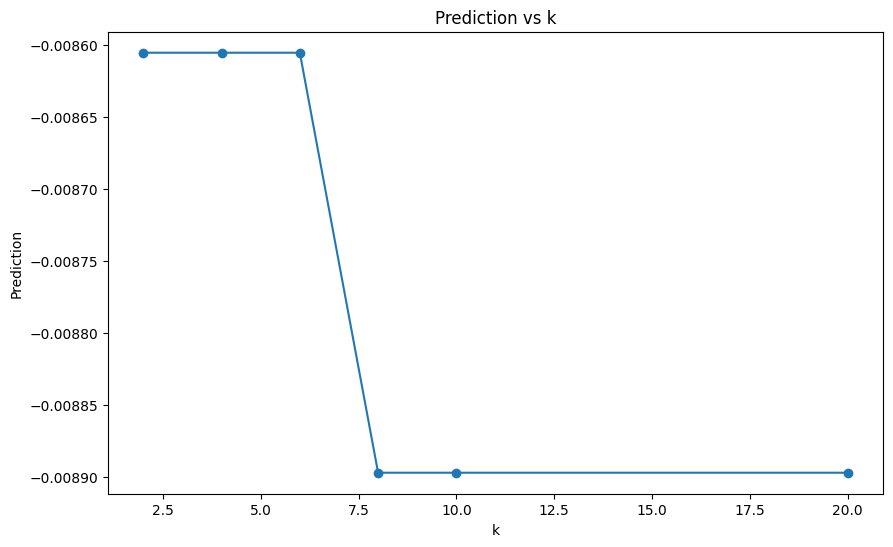

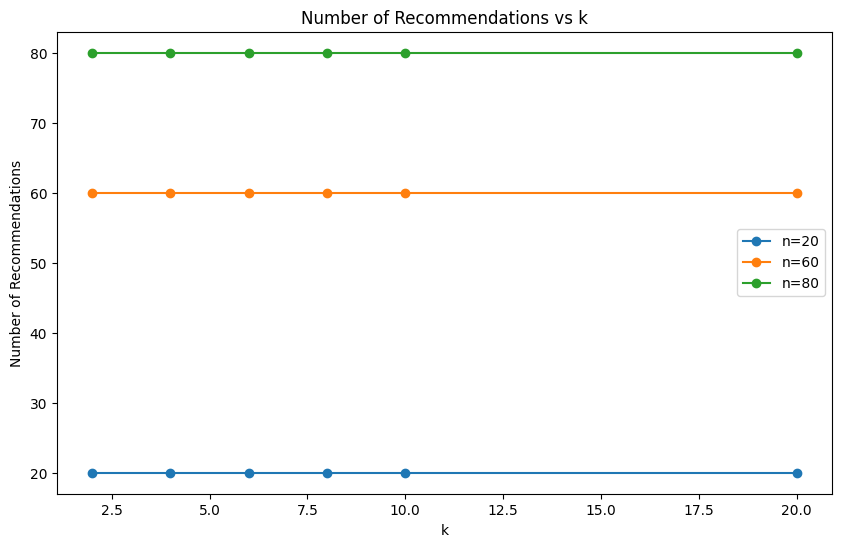

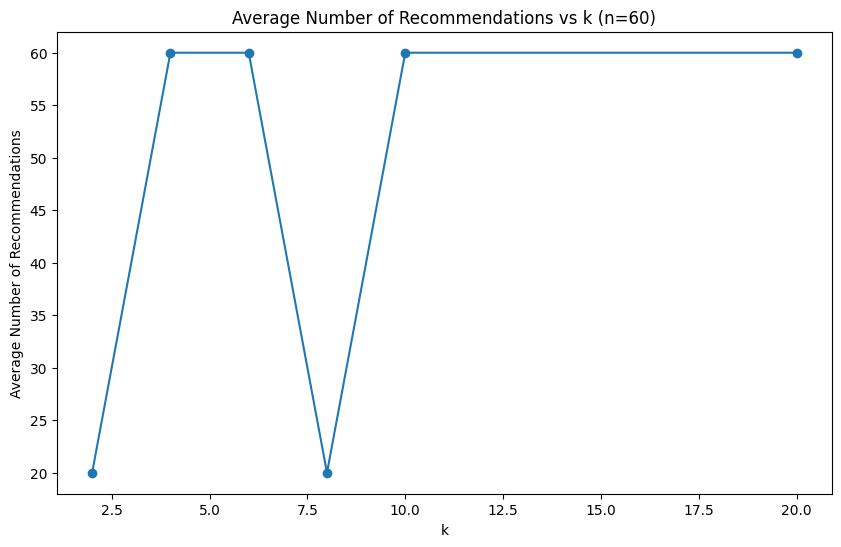

In [33]:

user_index = 0
item_index = movies.index("The Shawshank Redemption (1994)")
user_avarge_ratings = np.mean(R, axis=1)

k_list = [2, 4, 6, 8, 10, 20]
n_list = [20, 60, 80]

def recommender(user_index, item_index, n_list, k_list, R, movie_list, user_average_ratings, U_matrix, S_matrix, VT_matrix):
    """
    Recommends items to the user based on the given parameters

    args:
        user_index<int>: index of the user
        item_index<int>: index of the item
        n_list<list>: list of recommendation counts
        k_list<list>: list of reduced dimension counts
        R<np.Array>: user-item matrix
        movie_list<list>: list of movie names
        user_average_ratings<np.Array>: average ratings of users
        U_matrix<np.Array>: left singular vectors
        S_matrix<np.Array>: singular values
        VT_matrix<np.Array>: right singular vectors

    returns:
        output<list>: list of recommendations
    """

    output = list()

    for k_value in k_list:
        U_k = dim_reduction_U(U_matrix, k_value)
        S_k = dim_reduction_S(S_matrix, k_value)
        V_kT = dim_reduction_V(np.transpose(VT_matrix), k_value)

        n_items = np.sqrt(S_k) @ V_kT

        s = adjusted_cosine_similarity_matrix(n_items)

        prediction1, top_recommendations1 = prediction_generation(R, s, user_index, item_index, n_list[0], user_average_ratings)
        prediction2, top_recommendations2 = prediction_generation(R, s, user_index, item_index, n_list[1], user_average_ratings)
        prediction3, top_recommendations3 = prediction_generation(R, s, user_index, item_index, n_list[2], user_average_ratings)

        output.append([k_value, n_list[0], prediction1, top_recommendations1])
        output.append([k_value, n_list[1], prediction2, top_recommendations2])
        output.append([k_value, n_list[2], prediction3, top_recommendations3])

    return output

analysis_data = recommender(user_index, item_index, n_list, k_list, R_norm, movies, user_avarge_ratings, U, S, VT)

# do not take into consideration this cell's output, the plots are meaningless but kept in due to processing costs.

## Experiment No.1 Finding the Optimal $k$ Value

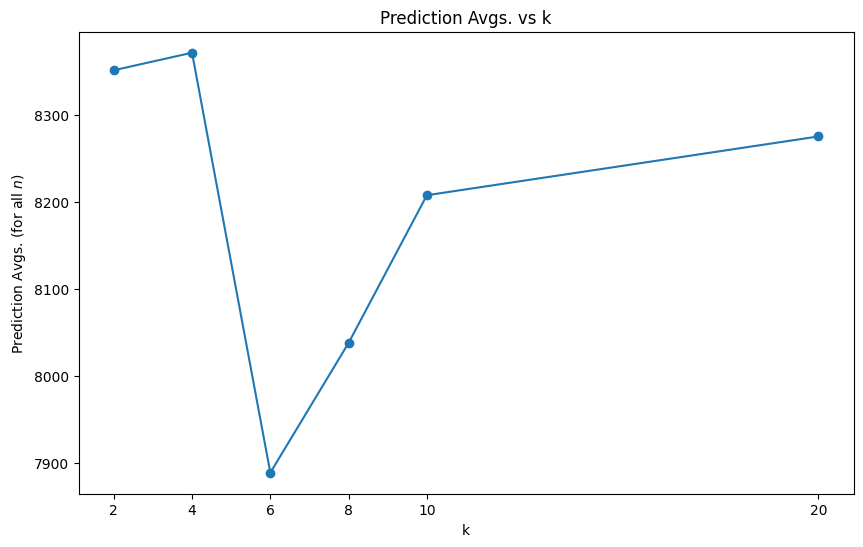

In [42]:
data_dict = dict()

for k_value in k_list:
    data_dict[k_value] = 0

for data in analysis_data:
    data_dict[data[0]] += np.mean(data[-1])

x_values = list()
y_values = list()

for k_value in k_list:
    if k_value in data_dict:
        x_values.append(k_value)
        y_values.append(data_dict[k_value])

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker="o")
plt.xticks(k_list)
plt.xlabel("k")
plt.ylabel("Prediction Avgs. (for all $n$)")
plt.title("Prediction Avgs. vs k")
plt.show()

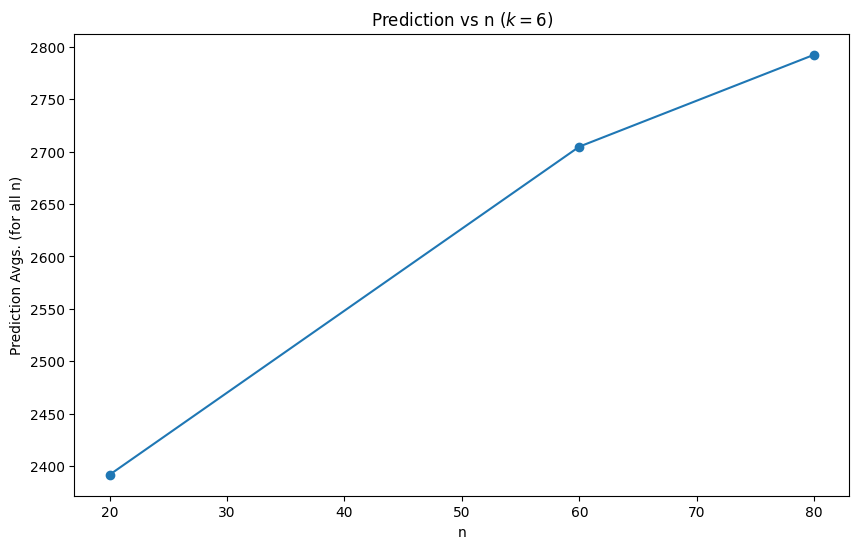

In [43]:
data_dict6 = dict()

for n_value in n_list:
    data_dict6[n_value] = 0

for data in analysis_data:
    if data[0] == 6:
        data_dict6[data[1]] += np.mean(data[-1])

x_values6 = list()
y_values6 = list()

for n_value in n_list:
    if n_value in data_dict6:
        x_values6.append(n_value)
        y_values6.append(data_dict6[n_value])

plt.figure(figsize=(10, 6))
plt.plot(x_values6, y_values6, marker="o")
plt.xlabel("n")
plt.ylabel("Prediction Avgs. (for all n)")
plt.title("Prediction vs n ($k=6$)")
plt.show()
